# Fitting shape models

#### Marcel Lüthi, Departement of Mathematics and Computer Science, University of Basel 


In this notebook we are fitting our model to a given contour and thereby obtain a distribution over 3D shapes, which can be used to obtain statistically meansingful reconstructions of the 3D shape from the data as well as the associated uncertainty. 

As always, we are starting with fitting simulated data, for which we know the ground truth. This allows us to check if the computational procedure works, before we assess the quality of our model on real data. 

### Setup

We begin as usual with importing all the necessary libraries. 

In [11]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

In [12]:

import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)

In [57]:
// downloading the libraries
import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`ch.unibas.cs.gravis::scalismo-renderer:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`


// imports
import scalismo.io.StatisticalModelIO
import scalismo.io.LandmarkIO
import scalismo.geometry._
import scalismo.common.PointId
import scalismo.common.interpolation.TriangleMeshInterpolator3D
import scalismo.common.UnstructuredPointsDomain
import scalismo.common.interpolation.NearestNeighborInterpolator3D
import scalismo.common.UnstructuredPointsDomain1D
import scalismo.common.UnstructuredPointsDomain3D
import scalismo.statisticalmodel.PointDistributionModel
import scalismo.statisticalmodel.MultivariateNormalDistribution

import scalismo.mesh.TriangleMesh
import scalismo.transformations._

import scalismo.renderer.Renderer
import scalismo.color.RGB
import scalismo.renderer.show

import scalismo.sampling._
import scalismo.sampling.proposals._
import scalismo.sampling.parameters._
import scalismo.sampling.evaluators._
import scalismo.sampling.loggers.MHSampleLogger
import scalismo.sampling.algorithms.MetropolisHastings
import scalismo.mesh.LineMesh
import scalismo.geometry._2D
import scalismo.renderer.{ContourRenderer, Renderer, show}

import breeze.linalg.DenseVector
import breeze.linalg.DenseMatrix
import breeze.stats.distributions.MultivariateGaussian
import breeze.stats.distributions.Rand.FixedSeed.randBasis

import java.io.File

In [58]:
given rng: scalismo.utils.Random = scalismo.utils.Random(42)

### Generating simulated data

In the last notebook, we have written a function to generate data. We use the same function here, but do not choose a random sample from the prior but one that we control:

In [59]:
def generate(vertebraModel : PointDistributionModel[_3D, TriangleMesh], shapeCoefficients : DenseVector[Double], sensorDistance : Int, sourceLocation : Point[_3D], noiseSigma : Double) : LineMesh[_2D] = 
    
    // sample from the prior    
    val sample = vertebraModel.instance(shapeCoefficients)

    // project the sampled shape to get the contour
    val sampledContour = ContourRenderer.projectMeshContours(sample, sensorDistance, sourceLocation)
    
    // add Gaussian noise to each point  
    val noiseTransform = Transformation2D( (point : Point[_2D]) => 
        val pointVec = DenseVector(point.x, point.y)
        val noise = MultivariateGaussian(pointVec, DenseMatrix.eye[Double](2)*noiseSigma)
        val newPoint = pointVec + noise.draw()
        Point2D(newPoint(0), newPoint(1))
    )                 
    sampledContour.transform(noiseTransform)

We can use this procedure to generate a ground truth:

In [63]:
val vertebraModel = StatisticalModelIO.readStatisticalTriangleMeshModel3D(File("./data/vertebra-model.h5")).get   
val coeffs = DenseVector.zeros[Double](vertebraModel.rank)
coeffs(0) = -3
coeffs(1) = +1
coeffs(2) = 1.5

val targetContour = generate(vertebraModel, coeffs, 100, Point3D(0, 0, 50), 10)

In [60]:
It looks as follows:

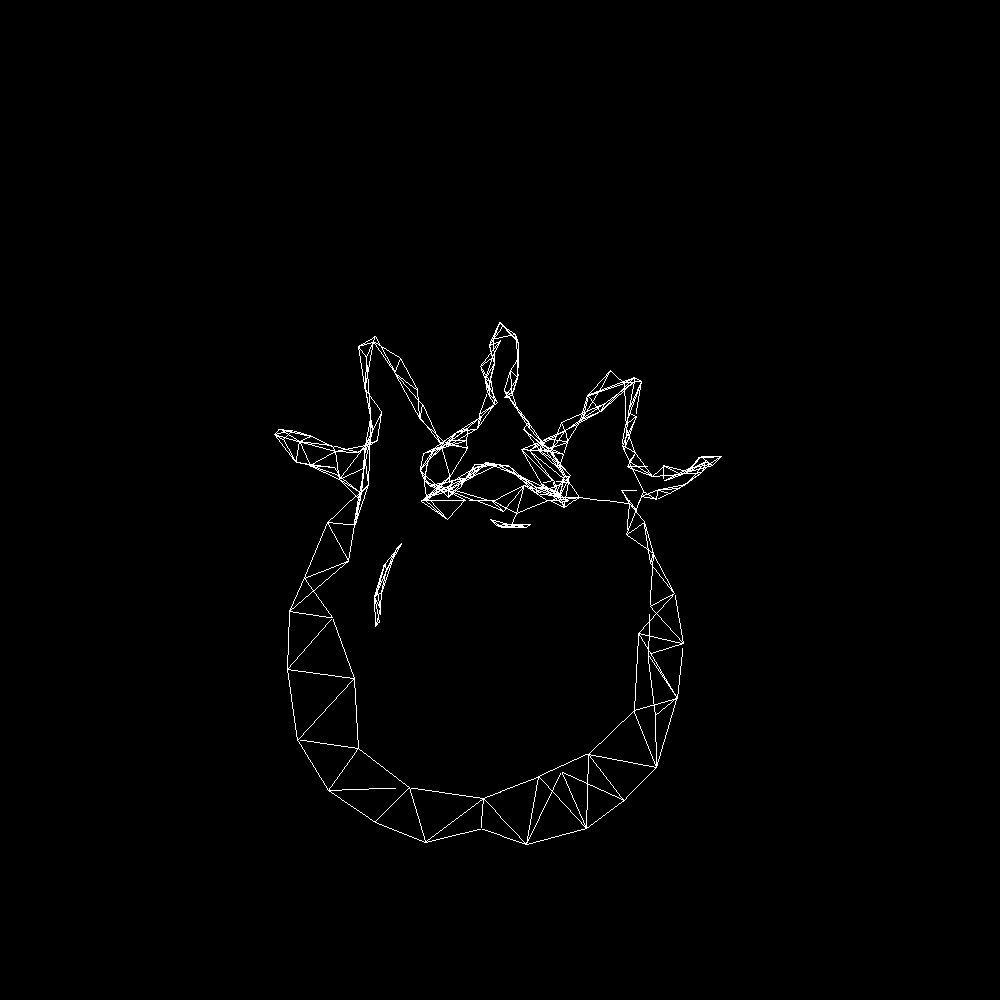

In [61]:
ContourRenderer.renderMeshContour(targetContour, 1000, 1000).show()

### Setting up the markov chain

We can now set up the Markov-Chain to sample from the posterior, exactly as we did it for the regression example:

#### Evaluators

We start with defining evaluators for the priors and the likelihood function. Note that we use the class `ShapeParameters`, instead of defining our own parameter vector. It is essentially defined as 

```scala 
case class ShapeParameters(coefficients : DenseVector[Double])
``` 
but adds some convenience functions that make it easier to work with the Scalismo sampling code. 

In [33]:
// Prior over the shape parameters.  
case class PriorEvaluator(model: PointDistributionModel[_3D, TriangleMesh])
      extends MHDistributionEvaluator[ShapeParameters] {
          
    val shapeParameterPrior = MultivariateGaussian(DenseVector.zeros[Double](model.rank), DenseMatrix.eye[Double](model.rank))
          
    override def logValue(sample: MHSample[ShapeParameters]): Double = {
        shapeParameterPrior.logPdf(sample.parameters.coefficients) 
    }
  }

In [36]:
// Likelihood
case class ContourEvaluator(
        model: PointDistributionModel[_3D, TriangleMesh],
        targetContour: LineMesh[_2D], 
        sensorDistance : Int, 
        sourceLocation : Point[_3D]
    ) extends MHDistributionEvaluator[ShapeParameters]:

    
    override def logValue(sample: MHSample[ShapeParameters]): Double = 
        val modelInstance = model.instance(sample.parameters.coefficients)
        val sampledContour = ContourRenderer.projectMeshContours(modelInstance, sensorDistance, sourceLocation)
        val sigma = 2.0
        val likelihoods = for targetPoint <- targetContour.pointSet.points yield
            val targetPointVec = DenseVector[Double](targetPoint.x, targetPoint.y)
            val dist = MultivariateGaussian(targetPointVec, DenseMatrix.eye[Double](2)*sigma)
            val closestModelPoint = sampledContour.pointSet.findClosestPoint(targetPoint).point
            val closestModelPointVec = DenseVector(closestModelPoint.x, closestModelPoint.y)
            dist.logPdf(closestModelPointVec)
        likelihoods.sum    

We can then define the posterior distribution, from which we eventually want to sample:

In [40]:
val likelihoodEvaluator = ContourEvaluator(vertebraModel, targetContour, sensorDistance, sourceLocation).cached
val priorEvaluator = PriorEvaluator(vertebraModel).cached
val posteriorEvaluator = ProductEvaluator(priorEvaluator, likelihoodEvaluator)

#### Proposals

Next we define the proposals for the Metropolis-Hastings algorithm. We use here a single proposal, which randomly perturbes the shape parameters:

In [42]:
val shapeProposal =
    GaussianRandomWalkProposal(0.1, "shape")
      .forType[ShapeParameters]

#### Putting it together

We can now put everything together:

In [44]:
val logger = MHSampleLogger[ShapeParameters]()
val chain = MetropolisHastings(shapeProposal, posteriorEvaluator)

val initialParameters = ShapeParameters(DenseVector.zeros[Double](vertebraModel.rank))
val mhIterator = chain.iterator(MHSample(initialParameters, "inital"), logger)

Let's draw some samples from the posterior:

In [50]:
val samples = mhIterator.drop(100).take(2000).toIndexedSeq

The most likely reconstruction is given by the sample with the highest posterior value

In [51]:
val bestSample = samples.maxBy(posteriorEvaluator.logValue)

Printing the coefficients reveals, that they are not exactly the same as the ground truth coefficients:

In [56]:
println(bestSample)

MHSample(ShapeParameters(DenseVector(-2.6213447803624006, -0.8897080480061008, 4.107168653402484, -1.1163205788909805, 2.781214967652799, 3.9733588694932096, -1.018160745278356, 0.6142583171858048, 4.415844512512358, -0.5376151899833093, -2.188763983628252, -1.169740988283992, 0.27896876404829396, 0.5436962741774775, 0.8207763436623784, -0.337794804418863, -2.229574113133654, -0.00533266370951337, -0.5207313053166325, 1.6478606277876948, -2.880178354235899, -0.432652385819241, -0.8767834782216247, -0.6628494542603435, -3.1486573842078416, 1.847491225241283, 1.4261254244689123, 2.247343425493559, 3.1775002246300197, 0.2809295161214938, 2.1328504540939752, 0.5894537480848963, 0.34945899912956846, 4.007897592403397, -0.5814801797171252, 0.16728833438733223, -0.5917242578061762, -1.0405754719605278, 1.4770812319389397, 0.6380896596688722, -0.7109790521115976, -0.8582542668437572, -2.114284246480722, -2.3931823337567852, -0.8555935397868396, 1.6487978382075381, 1.882433063973568, 0.69061217

This does not mean, however, that fitting did not work. Let's visualize the result:

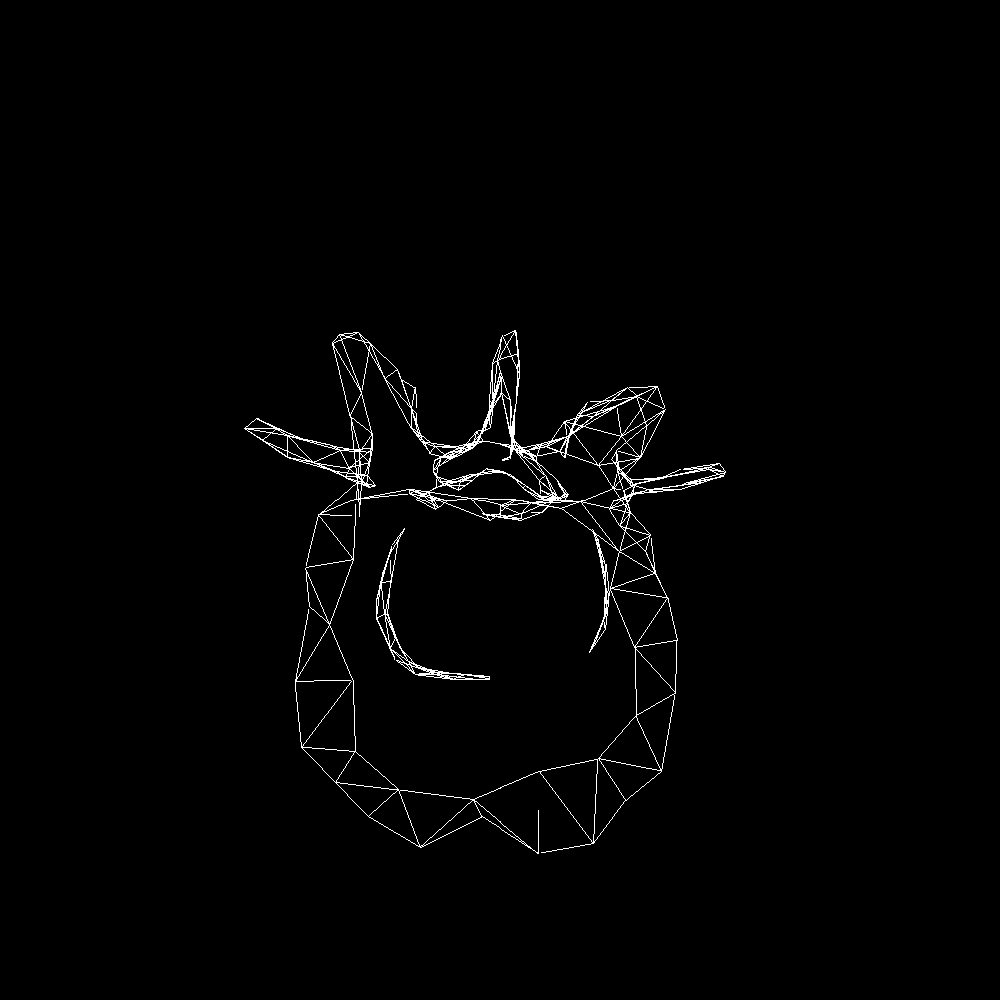

In [66]:
val bestMesh = vertebraModel.instance(bestSample.parameters.coefficients)
val bestConour = ContourRenderer.projectMeshContours(bestMesh, sensorDistance, sourceLocation)

ContourRenderer.renderMeshContour(bestConour, 1000, 1000).show()

TODO: We need a way to visualize the differences:

As we see, the two contours are really close together. Let's see how the reconstruction looks like:

In [69]:
def render(mesh: TriangleMesh[_3D]) : Unit =     
    val img = Renderer.renderMesh(mesh.transform(Scaling3D(0.01)), RGB.Black, 500, 500)
    img.show()


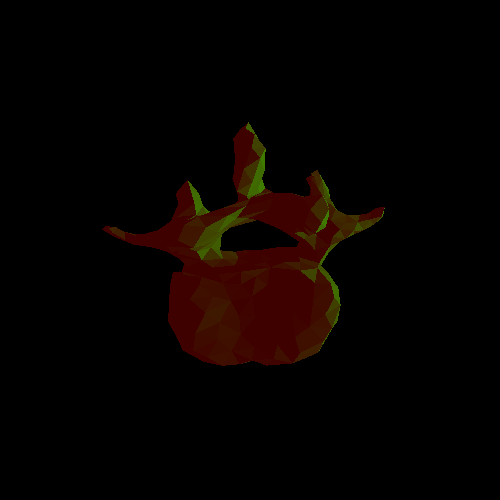

In [70]:
render(bestMesh)

#### Exercises

* Visualize some other samples from the posterior distribution. Do they look different or very similar? How well do they represent the target?
* Create pair-plots of the first 4 coefficients, as we did for the toy problem. What do you observe?
* How does the noise you choose affect the solution accuracy and the uncertainty?
* Try different parameters for the ground truth. Does the computational procedure also work for these parameters?
    * You will need to add additional proposals for these parameters. Think carefully about their scale and how large you should do the steps in the random walk
* Add additional parameters, such as pose or sensor distance to the procedure.
* Try to fit the hand-drawn conour `spine-contour-handdrawn`, which you find in the folder `images` It is a hand-drawn contour on the x-ray, which you also find in the folder. 